# Project 4 - Hackathon

Predict a bioresponse, https://www.kaggle.com/c/bioresponse/data. 

## Problem:

Create a model to predict the bioresponse of a given molecule based on its chemical properties. This problem is taken from a Kaggle competition. 

## Process/EDA


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import log_loss

%matplotlib

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using matplotlib backend: Qt5Agg


In [2]:

df_train_raw = pd.read_csv("./data/train.csv")

In [3]:
df_train_raw.head()


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train_raw.shape

(3751, 1777)

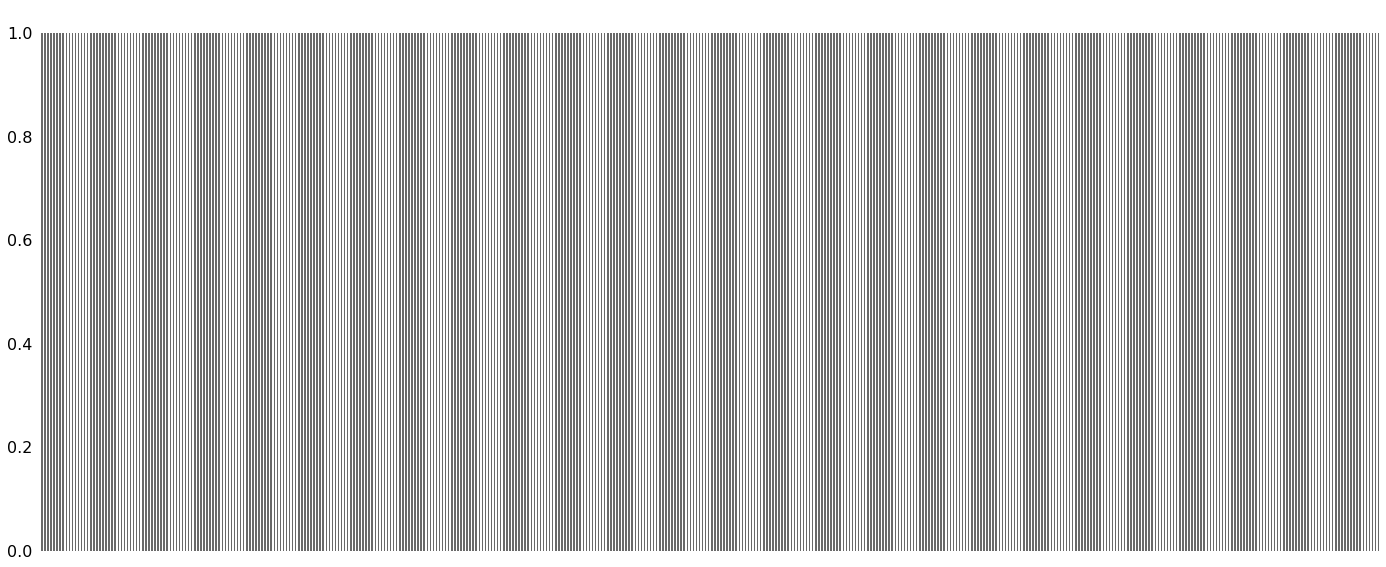

In [5]:
msno.bar(df_train_raw)

In [6]:
df_train_raw.isnull().sum().sum()

0

In [7]:
df_train_raw['Activity'].mean()


0.5422553985603839

In [8]:
# no null values, impressive
# according to the competition, the descriptor matrix is already normalized. Considering 
# that there seems to be a lot of one-hot encoding, using a transform on the data
# probably won't be advisable. Classes are conveniently balanced as well

X_tr = df_train_raw.drop(columns='Activity').copy()
y_tr = df_train_raw['Activity']

In [9]:
X_tr_train, X_tr_val, y_tr_train, y_tr_val = train_test_split(X_tr, y_tr, stratify=y_tr, random_state = 42)

In [10]:
# from experience, it pays to decrease variance with Kaggle competitions.
# since the data are so very clean, we can jump straight in to modeling

# lets start with a Random Forest Classifier, grid searching over 
# estimators, features, and depth:

rfc = RandomForestClassifier(random_state=42)
params = {
    'n_estimators' : [10, 50, 100, 200],
    'max_features' : [None, 'auto'],
    'max_depth' : [20, 50, 'auto'],
    'ccp_alpha' : [0, 0.1]
}
gs_rfc = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1, verbose=1)
gs_rfc.fit(X_tr_train, y_tr_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [11]:
gs_rfc.best_score_

0.8062546222258744

In [12]:
gs_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
gs_rfc.score(X_tr_val, y_tr_val)

0.767590618336887

In [14]:
# we seem to be somewhat overfit, so lets do the same, but with extra trees this time

etc = ExtraTreesClassifier(random_state=42)
params = {
    'n_estimators' : [50, 100, 200],
    'max_features' : [None, 'auto'],
    'max_depth' : [10, 20, 'auto'],
    'ccp_alpha' : [0, 0.1, 0.25]
}
gs_etc = GridSearchCV(etc, param_grid=params, cv=5, n_jobs=-1, verbose=1)
gs_etc.fit(X_tr_train, y_tr_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='deprecated'

In [15]:
gs_etc.best_score_

0.7998533529705505

In [16]:
gs_etc.score(X_tr_val, y_tr_val)

0.7697228144989339

In [17]:
gs_etc.best_params_

{'ccp_alpha': 0, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}

In [19]:
# marginally better, but not much better than the rfc.
# lets try an SVM:

svc = SVC()
params = {
    "C" : [0.1, 1, 10]
}

gs_svc = GridSearchCV(svc, param_grid=params, cv=5, n_jobs=-1, verbose=True)
gs_svc.fit(X_tr_train, y_tr_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [20]:
gs_svc.best_score_

0.7923926853473069

In [21]:
gs_svc.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
gs_svc.score(X_tr_val, y_tr_val)

0.7611940298507462

In [24]:
# so far, the etc model performs the best. Lets upload a test set to kaggle

kag_test = pd.read_csv('./data/test.csv')
kag_test.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,0.366667,0.611765,0.05,0.0,0.110435,0.803973,0.106075,0.473965,0.835617,0.106452,...,1,1,1,1,0,1,0,0,1,0
1,0.100000,0.758175,0.30,0.0,0.180128,0.621378,0.287144,0.503919,0.674919,0.403616,...,0,0,0,0,0,0,0,0,0,0
2,0.100000,0.658812,0.10,0.0,0.243421,0.640959,0.312765,0.279784,0.686775,0.280301,...,0,0,0,0,0,0,0,0,0,0
3,0.100000,0.655752,0.10,0.0,0.226978,0.776996,0.150657,0.336948,0.802121,0.125608,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.484851,0.00,0.0,0.561200,0.771463,0.244287,0.293096,0.717575,0.230842,...,0,0,0,0,0,0,0,0,0,0


In [25]:
submission = gs_etc.predict_proba(kag_test)

In [32]:
submission.shape

(2501, 2)

In [44]:
sub = pd.DataFrame(submission, columns=['zero', 'one'])
sub.head()

,zero,one
0,0.085000,0.915000
1,0.183719,0.816281
2,0.412974,0.587026
3,0.024604,0.975396
4,0.863750,0.136250


In [51]:
kag_sub = pd.DataFrame()
kag_sub['MoleculeId'] = sub.index + 1
kag_sub['PredictedProbability'] = sub['one']
kag_sub.head(10)

,MoleculeId,PredictedProbability
0,1,0.915000
1,2,0.816281
2,3,0.587026
3,4,0.975396
4,5,0.136250
5,6,0.649762
6,7,0.942880
7,8,0.731235
8,9,0.910453
9,10,0.446029


In [52]:
kag_sub.to_csv('Submission1.csv', index=False)

In [54]:
# lets try adjusting a few more parameters of the ETC gridsearch

etc = ExtraTreesClassifier(random_state=42)
params = {
    'n_estimators' : [100, 200, 300],
    'max_features' : [None, 'auto'],
    'max_depth' : [10, 20, 'auto'],
    'max_samples' : [1000, 2500, None],
    'min_samples_split' : [2, 10, 50],
    'max_features' : [500, 1000, 'auto']
}
gs_etc = GridSearchCV(etc, param_grid=params, cv=5, n_jobs=-1, verbose=1)
gs_etc.fit(X_tr_train, y_tr_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 29.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='deprecated'

In [55]:
gs_etc.best_score_


0.8101641561790863

In [56]:
gs_etc.score(X_tr_val, y_tr_val)

0.7697228144989339

In [57]:
gs_etc.best_params_

{'max_depth': 20,
 'max_features': 1000,
 'max_samples': 1000,
 'min_samples_split': 2,
 'n_estimators': 200}

In [58]:
# lets try a bagging classifier 

bgc = BaggingClassifier()
params = {
    'n_estimators' : [10, 20, 50],
    'max_features' : [.5, .75, 1],
    'max_samples' : [.5, .75, 1],
}
gs_bgc = GridSearchCV(bgc, param_grid=params, cv=5, n_jobs=-1, verbose=1)
gs_bgc.fit(X_tr_train, y_tr_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   57.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_features': [0.5, 0.75, 1],
                         'max_samples': [0.5, 0.75, 1],
                         'n_estimators': [10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [59]:
gs_bgc.best_score_

0.808386693046276

In [60]:
gs_bgc.score(X_tr_val, y_tr_val)

0.7814498933901919

In [ ]:
# marginal improvement